In [1]:
# # get data
# import os
# DIFFUSIONDB_IMGS_PATH = "/mnt/d/AiStuff/data/diffusionDB2M"
# PART1_IMGS = "diffusiondb-2m-part-0001-to-0100-of-2000"
# PART1_IMGS_PATH = os.path.join(DIFFUSIONDB_IMGS_PATH, PART1_IMGS)

# #csv
# import pandas as pd
# df = pd.read_parquet("../../datasets/diffusiondb2m/metadata.parquet")
# df.head()

In [2]:
# get data
import os
PART1_IMGS_PATH = "../../datasets/sampleeval"

#csv
import pandas as pd
df = pd.read_csv("../../datasets/sampleeval/prompts.csv")
df.head()

,imgId,prompt
0,20057f34d,hyper realistic photo of very friendly and dys...
1,227ef0887,"ramen carved out of fractal rose ebony, in the..."
2,92e911621,ultrasaurus holding a black bean taco in the w...
3,a4e1c55a9,a thundering retro robot crane inks on parchme...
4,c98f79f71,"portrait painting of a shimmering greek hero, ..."


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

# w, h = box[2] - box[0], box[3] - box[1]
# ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
def show_box_anns(anns, top_k=None):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['predicted_iou']), reverse=True)
    
    ax = plt.gca()
    ax.set_autoscale_on(False)
    
    c = 0

    for ann in sorted_anns:
        box = ann['bbox']
        x0, y0 = box[0], box[1]
        w,h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
        
        c += 1
        if c == top_k:
            break


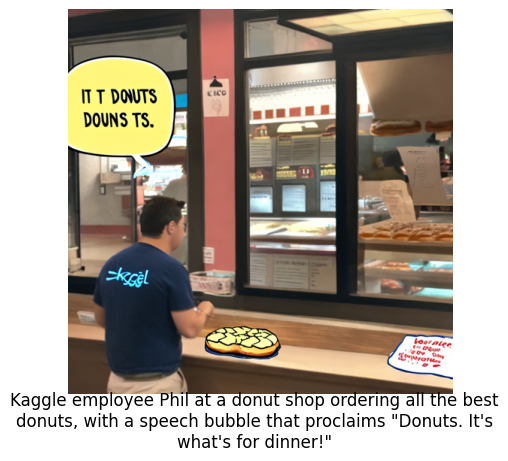

In [5]:
# idx = 1
# image = cv2.imread(os.path.join(PART1_IMGS_PATH, df.iloc[idx]['image_name'].replace(".png", ".jpg")))
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.figure(figsize=(5,5))
# plt.imshow(image)
# plt.figtext(0.5, 0.01, df.iloc[idx]['prompt'], wrap=True, horizontalalignment='center', fontsize=12)
# plt.axis('off')
# plt.show()

idx = 6
image = cv2.imread(os.path.join(PART1_IMGS_PATH, df.iloc[idx]['imgId']+".png"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.figtext(0.5, 0.01, df.iloc[idx]['prompt'], wrap=True, horizontalalignment='center', fontsize=12)
plt.axis('off')
plt.show()

In [11]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import time

sam_checkpoint = "../../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

start_time = time.time()

# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.half()
sam.eval()
sam.requires_grad_(False)
sam.to(device='cuda')

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=4,
    pred_iou_thresh=0.95,
    stability_score_thresh=0.95,
    min_mask_region_area=0,  # Requires open-cv to run post-processing
)

print(f"{(time.time() - start_time)} seconds to load")
# half - 5.916656732559204 seconds to load
    # cpu - 15.67760705947876 seconds to load
# full - 5.497025012969971 seconds to load
    # cpu - cannot load

5.534590721130371 seconds to load


In [12]:
from torch.cuda.amp import autocast

with autocast():
    for param in sam.parameters():
        print(param.dtype)

torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.float16
torch.

In [7]:
start_time = time.time()

# import torch autocast
from torch.cuda.amp import autocast

with autocast():
    masks = mask_generator.generate(image)

    
print(len(masks))
print(masks[0].keys())

print(f"{(time.time() - start_time)} seconds to generate")
# half - 0.7673399448394775 seconds to generate
    # cpu - not implemented
# full - 0.8575336933135986 seconds to generate

13
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
2.376617670059204 seconds to generate


In [8]:
def top_k_masks(masks, k):
    return sorted(masks, key=(lambda x: x['predicted_iou']), reverse=True)[:k]

print(len(top_k_masks(masks, 10)))
print(10-len(masks))

10
-3


x0=34, x1=134, y0=175, y1=310


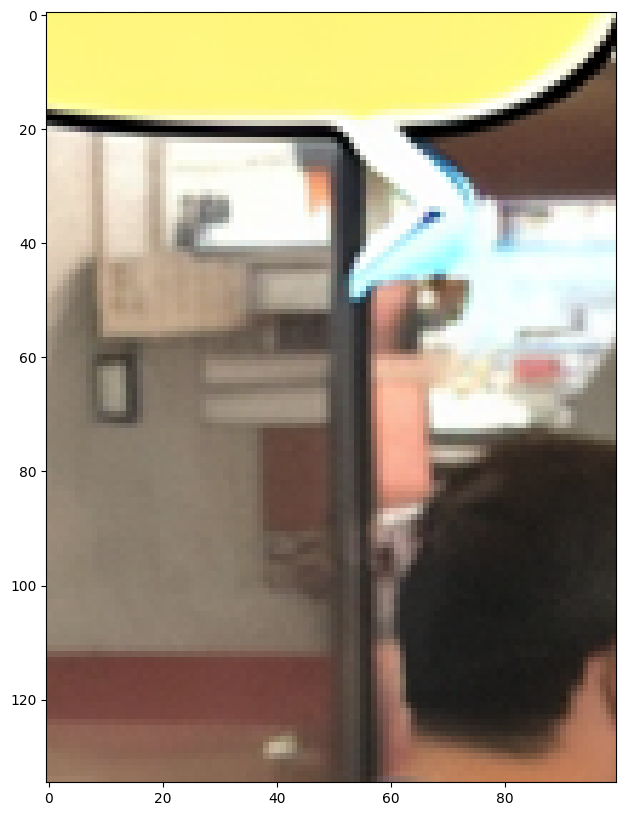

In [9]:
def crops(image, masks, top_k=1):
    if len(masks) == 0:
        return image
    sorted_anns = sorted(masks, key=(lambda x: x['predicted_iou']), reverse=True)
    
    x0, y0, x1, y1 = sorted_anns[0]['bbox']
    if x0 > x1:
        x0, x1 = x1, x0
    if y0 > y1:
        y0, y1 = y1, y0

    crop = image[y0:y1, x0:x1, :]
    return crop

x0, y0, x1, y1 = masks[0]['bbox']
if x0 > x1:
    x0, x1 = x1, x0
if y0 > y1:
    y0, y1 = y1, y0

print(f"{x0=}, {x1=}, {y0=}, {y1=}")
        
crop = image[y0:y1, x0:x1, :]
plt.figure(figsize=(10,10))
plt.imshow(crop)

In [15]:
torch.tensor(image).shape

torch.Size([512, 512, 3])

ValueError: pic should not have > 4 channels. Got 135 channels.

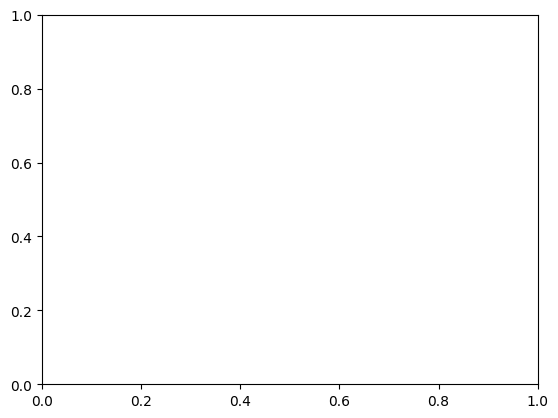

In [19]:
import torchvision.transforms.functional as F
import torchvision.transforms as T
# T.Resize((14, 14))(torch.tensor(crop))

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
show([T.Resize((14, 14))(torch.tensor(crop))])

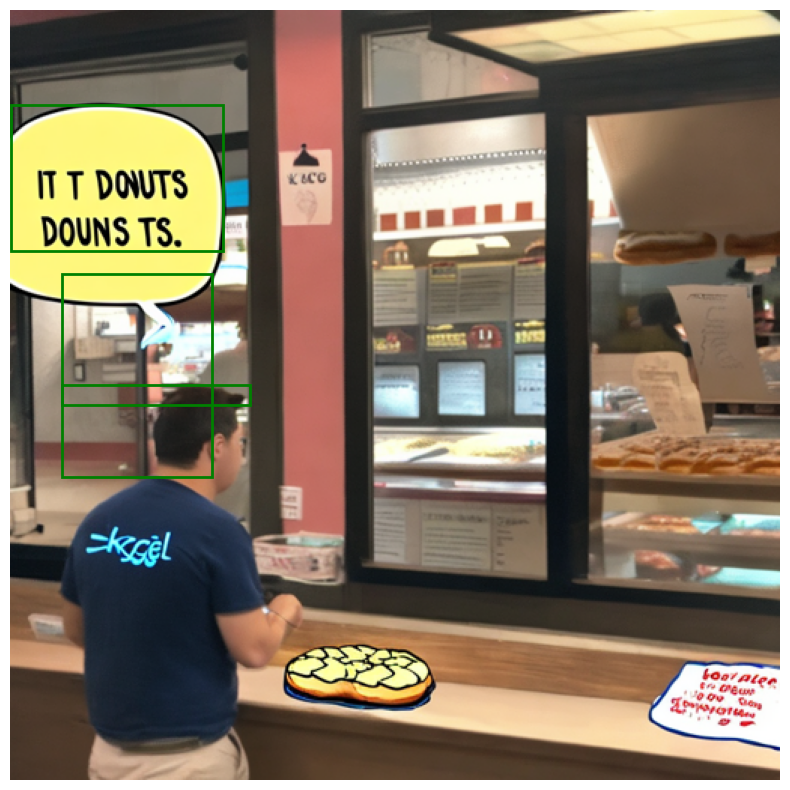

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
# show_anns(masks)
show_box_anns(top_k_masks(masks, 3))
plt.axis('off')
plt.show()